In [1]:
import pandas as pd
import numpy as np
import os
import transformers
import random
import math
import json
from itertools import chain
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration

import warnings
warnings.filterwarnings('ignore')

In [2]:
# GLOBAL VARIABLES
test_name = '100Agents100Timesteps_Jan18'
connectionCap = 0.3 #Percentage the of total number of agents
preferenceDataFrame = pd.read_json('~/Documents/Research/Data/Conversation Data/archive/GODEL_finetune.json')

connectionCap = 0.3 #Percentage the of total number of agents
preferenceDataFrame = pd.read_json('~/Documents/Research/Data/Conversation Data/archive/GODEL_finetune.json')

simDuration = 5
numAgents = 30



In [3]:
class Agent:
    def __init__(self, name, preference, connections, chats, hist):
        self.name = int(name) #Agent Number
        self.preference = preference #An actual document stored in a DF correspoding to the Agent Number, will serve as first message.
        self.connections = connections #A list of  other agents this agent is following
        self.chats = chats #A dictionary of all the chat lists this person has received from all the other agents its connected
        self.history = hist #A list of chat history this agent with another agent it is connected to
        self.conversationRecord = pd.DataFrame(columns=['sender','receiver','message'])
        self.model = AutoModelForSeq2SeqLM.from_pretrained("microsoft/GODEL-v1_1-base-seq2seq")
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/GODEL-v1_1-base-seq2seq")
    
    def sendChat(self, target, message):
        if target.name not in self.chats.keys():
            self.chats[target.name] =  [message]
        else:
            self.chats[target.name].append(message) #str(chain.from_iterable(message)))    
        
        self.conversationRecord = self.conversationRecord.append({'sender': self.name, 'receiver': target.name, 'message': message}, ignore_index=True)  
        self.history.append(message)
        #print('Agent %s has sent a message to Agent %s.' % (self.name, target.name))
    
    def receiveChat(self, source, message):
        if source.name not in self.chats.keys():
            self.chats[source.name] =  [message]
        else:
            self.chats[source.name].append(message)#self.chats[source.name] + '~ ' + str(source.name) + ': ' + message
        
        self.conversationRecord = self.conversationRecord.append({'sender': source.name, 'receiver': self.name, 'message': message}, ignore_index=True)
        self.history.append(message)
        #print('Agent %s has received a message from Agent %s.' % (self.name, source.name))
        
    
    def generateMessage(self, target):
        # Instruction for a chitchat task
        instruction = f'Instruction: given a dialog context, you need to response empathically.'
        if self.history != '':
            knowledge = '[KNOWLEDGE] ' + ' '.join(map(str, self.history))
        dialog = ' EOS '.join(self.chats[target.name])
        query = f"{instruction} [CONTEXT] {dialog} {knowledge}"
        input_ids = self.tokenizer(f"{query}", return_tensors="pt").input_ids
        outputs = self.model.generate(input_ids, max_length=128, min_length=8, top_p=0.9, do_sample=True)
        output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return output
    
    def batchGenerateMessage(self):
        list(chain.from_iterable(map(lambda s,t,: [self.generateMessage(s,i) for i in t], 
                        {k: v for k, v in self.agentDict.items()}.values(),
                        {k: v.connections for k, v in self.agentDict.items()}.values())))
        

In [5]:
class SocialNetwork:
    def __init__(self):
        self.agentDict = {}
        self.agentMatrix = pd.DataFrame(columns=['agent', 'agent_preference', 'num_connections', 'agent_connections'])
        #self.model = AutoModelForSeq2SeqLM.from_pretrained("microsoft/GODEL-v1_1-base-seq2seq")
        #self.tokenizer = AutoTokenizer.from_pretrained("microsoft/GODEL-v1_1-base-seq2seq")
        
    def referenceConnections(self, agent, connections):
        return agent in connections

    def generateAgents(self, numAgents): #Generates a number of random agents depending on the value inputted   
        #Define the number of connections an agent can have in the current environment
        maxConnections = int(math.floor(connectionCap*numAgents))
    
        for i in range(1,numAgents+1):
            #Prepare random connections per agent
            numConnections = random.randint(1,maxConnections)
            possibleConnections = list(range(1,numAgents+1))
            possibleConnections.remove(i)
            agentConnections = random.sample(possibleConnections, numConnections)
            
            #Prepare preference per agent
            agentPreference = preferenceDataFrame['Knowledge'][i]
            
            #Instantiate Agent in a list with the index as the name, preference, connections, empty chathistory list, and an empty chat dictonary.
            self.agentDict[i] = Agent(str(i), agentPreference, agentConnections, {}, [])
            
            #Capture Agent instatiation data
            self.agentMatrix.loc[i]= {'agent': i,'agent_preference': agentPreference, 'num_connections': numConnections, 'agent_connections': agentConnections}
            
            #Confirm Agent creation    
            print('Agent %d has been created with %d outgoing connections.' % (i, numConnections))
            
         # Dictionary comprehension to create a list of object references
        for i in range(1,numAgents+1):
          filteredDictionary = dict(filter(lambda x:x[0] in self.agentDict[i].connections, self.agentDict.items()))
          self.agentDict[i].connections = [v for v in filteredDictionary.values()]
            
            
    def sendMessage(self, source, target, message):
        if target in source.connections:
            self.agentDict[source.name].sendChat(self.agentDict[target.name],message)
            self.agentDict[target.name].receiveChat(self.agentDict[source.name],message)
            print('Agent %s has sent a message to Agent %s.' % (source.name, target.name))
        #Enter try-catch here, but this should not even happen as we control the simulation 
        
    def firstBatchMessage(self):
       flogs = list(map(lambda x,y,z: [self.sendMessage(x,i,z) for i in y], 
                        {k: v for k, v in self.agentDict.items()}.values(),
                        {k: v.connections for k, v in self.agentDict.items()}.values(), 
                        {k: v.preference for k, v in self.agentDict.items()}.values()))
       print(flogs)
    
    def createMessage(self, source, target):
        # Instruction for a chitchat task
        instruction = f'Instruction: given a dialog context, you need to response empathically.'
        if source.history != '':
            knowledge = '[KNOWLEDGE] ' + ' '.join(map(str, source.history[-20:]))
        dialog = source.chats[target.name] #' EOS '.join(str(chain.from_iterable(source.chats[target.name])))
        query = f"{instruction} [CONTEXT] {dialog} {knowledge}"
        input_ids = self.tokenizer(f"{query}", return_tensors="pt").input_ids
        outputs = self.model.generate(input_ids, max_length=128, min_length=8, top_p=0.9, do_sample=True)
        output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return output
     
    def batchMessage(self):
        logs = list(map(lambda x,y,z: [self.sendMessage(x,i,z) for i in y], 
                        {k: v for k, v in self.agentDict.items()}.values(),
                        {k: v.connections for k, v in self.agentDict.items()}.values(), 
                        {k: v. for k, v in self.agentDict.items()}.values()))
                        
        print(logs)
        
       

# Test Cases for Sending and Creating Messages

In [ ]:
logs = list(map(lambda x,y,z: [twitter.sendMessage(x,i,z) for i in y], 
    {k: v for k, v in twitter.agentDict.items()}.values(),
    {k: v.connections for k, v in twitter.agentDict.items()}.values(), 
    {k: v.preference for k, v in twitter.agentDict.items()}.values()))

print(logs)

In [ ]:
logs = list(map(lambda x,y,z: [twitter.sendMessage(x,i,z) for i in y], 
                        {k: v for k, v in twitter.agentDict.items()}.values(),
                        {k: v.connections for k, v in twitter.agentDict.items()}.values(), 
                        list(chain.from_iterable(map(lambda s,t,: [twitter.createMessage(s,i) for i in t], 
                        {k: v for k, v in twitter.agentDict.items()}.values(),
                        {k: v.connections for k, v in twitter.agentDict.items()}.values())))))
print(logs)

# Main Method While Loop

In [6]:
timestep = 0
twitter = SocialNetwork()
twitter.generateAgents(10)
twitter.firstBatchMessage()

while timestep <= 5:
    timestep += 1
    twitter.batchMessage()
    print(timestep)
    

Agent 1 has been created with 1 outgoing connections.
Agent 2 has been created with 2 outgoing connections.
Agent 3 has been created with 2 outgoing connections.
Agent 4 has been created with 3 outgoing connections.
Agent 5 has been created with 3 outgoing connections.
Agent 6 has been created with 2 outgoing connections.
Agent 7 has been created with 3 outgoing connections.
Agent 8 has been created with 1 outgoing connections.
Agent 9 has been created with 1 outgoing connections.
Agent 10 has been created with 3 outgoing connections.
Agent 1 has sent a message to Agent 7.
Agent 2 has sent a message to Agent 1.
Agent 2 has sent a message to Agent 9.
Agent 3 has sent a message to Agent 5.
Agent 3 has sent a message to Agent 6.
Agent 4 has sent a message to Agent 1.
Agent 4 has sent a message to Agent 2.
Agent 4 has sent a message to Agent 10.
Agent 5 has sent a message to Agent 3.
Agent 5 has sent a message to Agent 6.
Agent 5 has sent a message to Agent 8.
Agent 6 has sent a message to

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


Agent 1 has sent a message to Agent 7.
Agent 2 has sent a message to Agent 1.
Agent 2 has sent a message to Agent 9.
Agent 3 has sent a message to Agent 5.
Agent 3 has sent a message to Agent 6.
Agent 4 has sent a message to Agent 1.
Agent 4 has sent a message to Agent 2.
Agent 4 has sent a message to Agent 10.
Agent 5 has sent a message to Agent 3.
Agent 5 has sent a message to Agent 6.
Agent 5 has sent a message to Agent 8.
Agent 6 has sent a message to Agent 9.
Agent 6 has sent a message to Agent 10.
Agent 7 has sent a message to Agent 2.
Agent 7 has sent a message to Agent 3.
Agent 7 has sent a message to Agent 6.
Agent 8 has sent a message to Agent 3.
Agent 9 has sent a message to Agent 10.
Agent 10 has sent a message to Agent 1.
Agent 10 has sent a message to Agent 4.
Agent 10 has sent a message to Agent 5.
[[None], [None, None], [None, None], [None, None, None], [None, None, None], [None, None], [None, None, None], [None], [None], [None, None, None]]
2
Agent 1 has sent a message

In [7]:
twitter.agentDF.head(10)

,agent,agent_preference,num_connections,agent_connections
1,1,extraordinary evidence at treasury committee f...,1,[7]
2,2,the brexiter favourite max fac would cost bus...,2,"[1, 9]"
3,3,how does he arrive at the figurem export consi...,2,"[6, 5]"
4,4,theresa mays new customs partnership is much c...,3,"[1, 10, 2]"
5,5,mr thompson said he did not expect the eu to r...,3,"[6, 8, 3]"
6,6,both would not be ready by max fac needs yea...,2,"[10, 9]"
7,7,is under so many federal investigations and re...,3,"[2, 6, 3]"
8,8,is under so many federal investigations and re...,1,[3]
9,9,investigations through all of these are unde...,1,[10]
10,10,is also reviewing whether s pal samantha dravi...,3,"[1, 4, 5]"


# File Exporting

In [51]:
agentDF = pd.DataFrame(twitter.agentMatrix)
agentDF.to_csv('%s_Agents.csv' % (test_name))

In [820]:
json_data = json.dumps(twitter.agentDict[1].chats, indent=4, separators=(',', ': '))

with open("agent1.json", "w") as outfile:
    # Write the dictionary to the file in JSON format
    json.dump(json_data, outfile)

In [ ]:
#Export Chats
dfs = {}

for key, value in {k: v.chats for k, v in twitter.agentDict.items()}.items():
    # Convert the list to a DataFrame and store it in the dictionary
    dfs[key] = pd.DataFrame(value)

    #pd.DataFrame(value).to_csv(f"Agent{key}.csv")

In [ ]:
dfs = pd.DataFrame(columns=['receiver','message'])
for key, value in {k: v.chats for k, v in twitter.agentDict.items()}.items():
    # Unpack the inner dictionary
    #dfs[key] = pd.DataFrame(columns = ['corresponding agent','conversation list'])
    #for list in value:
        #dfs[key].append(str(key),list)
        #print(value[list])
         temp = pd.DataFrame(value.items())
         temp.to_csv(f'10_10ConversationRecord_Agent{key}.csv')
         print(temp)
         dfs.append(temp, ignore_index = True)     
dfs.to_csv(f'10_10ConversationRecord.csv')
    #for inner_key, inner_value in value.items():
        #print(pd.DataFrame(inner_value))
        #dfs[inner_key] = pd.DataFrame(inner_value)
        #pd.DataFrame(inner_value).to_csv(f"Agent{inner_key}.csv")

In [8]:
{k: v.chats for k, v in twitter.agentDict.items()}

{1: {7: ['extraordinary evidence at treasury committee from jon thompson ceo of hmrc on customs and brexit today',
   'ah, i see. what a great brexiter, i loved max fac and it costs over an billion a year',
   'It’s not a matter of how much it costs to get a license, it’s that the EU is so busy bribing the EU over all the information that its almost impossible to keep track of the status of the figurem export consignments',
   'How much of a brexiter?',
   "He said he doesn't expect the eu to reciprocate over the customs partnership. Why not just try to negotiate the terms of trade and just have a deal?",
   'I know that you would like to know some more information on the European Trade Agency:',
   'The figurem export consignments are so cheap that the cost to obtain a license is more than what is required.'],
  2: ['the brexiter favourite max fac  would cost business between  and bn a year thats almost  of gdp jus',
   'theresa mays new customs partnership is much cheaper for busines

In [24]:
#Output conversation records per agent to separate CSV
for agent in twitter.agentDict.values():
    convoRecDF = agent.conversationRecord
    convoRecDF.to_csv('Agent%s_Convos.csv' % (agent.name))

In [33]:
#Output conversation records of all agent to one CSV
genConvoRecDF = pd.DataFrame()
for agent in twitter.agentDict.values():
    genConvoRecDF = pd.concat([genConvoRecDF, agent.conversationRecord], ignore_index=True)
    
genConvoRecDF.to_csv('%s_Convos.csv' % (test_name))

# Network Visualization

In [37]:
import networkx as nx

In [52]:
agentDF_Graph = agentDF.explode('agent_connections')
agentDF_Graph.to_csv('%s_Graph.csv' % (test_name))
agentDF_Graph.head()

In [39]:
G = nx.from_pandas_edgelist(agentDF_Graph, source='agent', target='agent_connections')

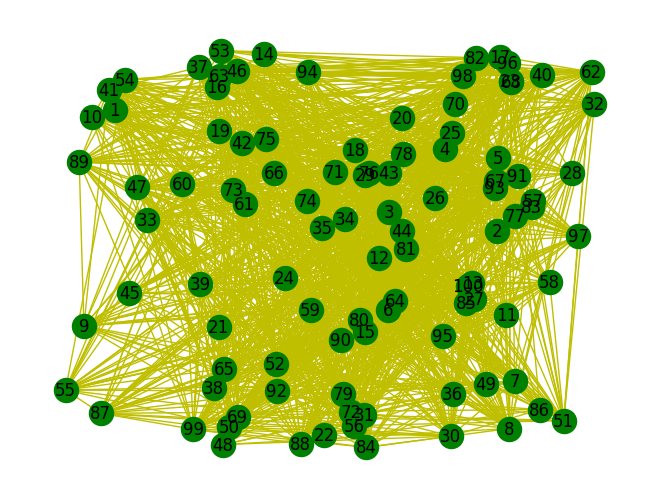

In [50]:
nx.draw_random(G, node_color='g', edge_color='y', with_labels = True)